# Train models on subsets

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import argparse
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables fast auto-tuning


# Time tracking decorator
def time_tracker(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"Starting {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.2f} seconds to execute.")
        return result
    return wrapper

# Split data into training, validation, and test sets
@time_tracker
def sample_data(numerical_data_filtered, labels_encoded, split_size, random_state=42):
    if split_size == 'shuffled_10000':
        return generate_shuffled_data(numerical_data_filtered, 10000, random_state)
    else:
        size = int(split_size)
        if size < len(numerical_data_filtered):
            print(f"Splitting data with size: {size}")
            splitter = StratifiedShuffleSplit(n_splits=1, train_size=size, random_state=random_state)
            for train_idx, _ in splitter.split(numerical_data_filtered, labels_encoded):
                return numerical_data_filtered.iloc[train_idx], [labels_encoded[i] for i in train_idx]
        else:
            return numerical_data_filtered, labels_encoded


@time_tracker
def train_val_test_split(data, labels, random_state=42):
    print("Splitting data into training, validation, and test sets...")
    
    # Convert labels list to pandas Series to use value_counts()
    import pandas as pd
    labels_series = pd.Series(labels, index=data.index)
    
    # Filter labels to exclude classes with fewer than 20 samples
    label_counts = labels_series.value_counts()
    valid_labels = label_counts[label_counts > 20].index

    # Select only data and labels corresponding to classes with more than 20 samples
    valid_indices = labels_series.isin(valid_labels)
    data_filtered = data.loc[valid_indices]
    labels_filtered = labels_series.loc[valid_indices]

    # Perform the split with stratification on filtered data
    from sklearn.model_selection import train_test_split

    X_train, X_remaining, y_train, y_remaining = train_test_split(
        data_filtered, labels_filtered, test_size=0.3, random_state=random_state, stratify=labels_filtered
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining, y_remaining, test_size=0.4, random_state=random_state, stratify=y_remaining
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test



@time_tracker
def scale_and_save_data(train_val_test_splits, output_path):
    scaler = StandardScaler()
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_splits
    print(f"Scaling and saving data...")
    
    # Scaling the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Converting to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Convert labels to numpy arrays before converting to tensors
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

    # Creating TensorDataset objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create output directory if it does not exist
    dataset_path = f'{output_path}/{split_data_value}/'
    directory_path = Path(dataset_path)
    directory_path.mkdir(parents=True, exist_ok=True)

    # Save the datasets
    torch.save(train_dataset.tensors, f'{dataset_path}train_dataset_tensors.pt')
    torch.save(val_dataset.tensors, f'{dataset_path}val_dataset_tensors.pt')
    torch.save(test_dataset.tensors, f'{dataset_path}test_dataset_tensors.pt')
    print(f"Data saved successfully.")


@time_tracker
def generate_shuffled_data(numerical_data_filtered, size, random_state=42):
    print("Generating shuffled data for null hypothesis...")
    flattened_values = numerical_data_filtered.values.flatten()
    np.random.seed(random_state)
    np.random.shuffle(flattened_values)
    shuffled_matrix = flattened_values.reshape(numerical_data_filtered.shape)
    shuffled_data = pd.DataFrame(shuffled_matrix, columns=numerical_data_filtered.columns).sample(n=size, random_state=random_state).reset_index(drop=True)
    shuffled_labels = [0] * size  # Use dummy labels to represent null hypothesis
    return shuffled_data, shuffled_labels




In [2]:
set_seed(42)


In [3]:
data_sizes = ['5000', '10000', '20000', '37067', 'shuffled_10000']

In [4]:
import os

# Set the environment variable inside the script
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


# Build VAE

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[2048,1024,512], dropout_rate=0.2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder_layers = self.build_layers(input_dim, hidden_dims, dropout_rate)
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)  # for mean
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)  # for log variance
        
        # Decoder
        decoder_hidden_dims = hidden_dims[::-1]
        self.decoder_layers =self.build_layers(latent_dim, decoder_hidden_dims, dropout_rate)
        self.fc_output = nn.Linear(hidden_dims[0], input_dim)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def build_layers(self, input_dim, hidden_dims, dropout_rate):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def encode(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Check if logvar has NaN or Inf values
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN or Inf detected in logvar: logvar={logvar}")
        
        # Clamp logvar to prevent extreme values
        logvar = torch.clamp(logvar, min=-5, max=5)
        
        # Calculate std from logvar
        std = torch.exp(0.5 * logvar)
        
        # Check if std has NaN or Inf values
        if torch.isnan(std).any() or torch.isinf(std).any():
            print(f"NaN or Inf detected in std computation: std={std}")
        
        # Sample from the latent space
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Check if z has NaN or Inf values
        if torch.isnan(z).any() or torch.isinf(z).any():
            print(f"NaN or Inf detected in z computation: z={z}")
        
        return z

    def decode(self, z):
        h = self.decoder_layers(z)
        # h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc_output(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent_embedding(self, x):
        """
        Method to get the latent embedding (the `z` vector) for an input.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)  # this is the embedding
        return z


In [6]:
class VAE_Lightning(pl.LightningModule):
    def __init__(self, input_dim=485577, latent_dim=128, hidden_dims=[2048, 1024, 512], dropout_rate=0.2, lr=1e-6):
        super(VAE_Lightning, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        self.model = VAE(input_dim, latent_dim, hidden_dims, dropout_rate)
        self.lr = lr
    
    def forward(self, x):
        mu, logvar = self.model.encode(x)
        z = self.model.reparameterize(mu, logvar)
        return z, mu, logvar

    def get_latent_embedding(self, x):
        return self.model.get_latent_embedding(x)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)  # mask where values are not NaN

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Training loss: {loss.item()}")

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Validation loss: {loss.item()}")

        self.log('val_loss', loss, on_step=False, on_epoch=True)
  

    def _vae_loss(self, original_x, x_hat, mu, logvar, mask):
        # Apply mask to ignore NaN values in the loss calculation
        recon_loss = F.mse_loss(x_hat[mask], original_x[mask], reduction='mean')
    
        # Scale the KL divergence to balance the losses
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss = kl_loss / original_x.shape[0]  # Normalize by batch size or apply weighting
    
        return recon_loss + kl_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [7]:
from pytorch_lightning.callbacks import Callback

class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the loss for the last training epoch from the logs
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the loss for the last validation epoch from the logs
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())



def replace_nan_with_mean(x):
    # Calculate the column-wise mean, ignoring NaNs
    col_mean = torch.nanmean(x, dim=0)
    
    # Find where NaN values are located
    nan_mask = torch.isnan(x)
    
    # Replace NaNs with the corresponding column means
    x[nan_mask] = torch.take(col_mean, nan_mask.nonzero()[:, 1])
    
    # Check if there are still NaN or Inf values
    if torch.isnan(x).any() or torch.isinf(x).any():
        print("NaN or Inf detected in the input data after imputation!")
    
    return x

## Train VAE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
%%time
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer, loggers

data_size = '5000'
dataset_path = 'data/v2/m1/'

for data_size in data_sizes:
    
    # This loads both X (features) and y (labels) from the saved files
    train_tensors = torch.load("/".join([dataset_path, data_size, "train_dataset_tensors.pt"]))  # Loads (X_train, y_train)
    val_tensors = torch.load("/".join([dataset_path, data_size, "val_dataset_tensors.pt"]))      # Loads (X_val, y_val)
    test_tensors = torch.load("/".join([dataset_path, data_size, "test_dataset_tensors.pt"]))    # Loads (X_test, y_test)
    
    # Recreate the TensorDataset
    train_dataset = TensorDataset(*train_tensors)
    val_dataset = TensorDataset(*val_tensors)
    test_dataset = TensorDataset(*test_tensors)
    
    # Create DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
    
    # Create a logger
    logger = loggers.CSVLogger('lightning_logs/', name=f'v2_m1_vae_{data_size}')
    
    
    pl.seed_everything(42)
    
    # Initialize the VAE Lightning model
    input_dim = train_tensors[0].shape[1]  # The number of input features
    # input_dim = X_train_tensor.shape[1]  # The number of input features
    latent_dim = 256  # Latent dimension size, can be tuned
    hidden_dims = [2048, 1024, 512]
    dropout_rate = 0.2
    lr = 1e-6
    
    model = VAE_Lightning(
        input_dim=input_dim,
        latent_dim=latent_dim,
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate,
        lr=lr)
    
    # Training
    loss_history_callback = LossHistoryCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        save_top_k=1,
        mode='min',
        dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
        filename='m1-vae-{epoch:02d}-{val_loss:.2f}'
        )
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
    
    trainer = pl.Trainer(
        max_epochs=200,
        gradient_clip_val=0.1,  # Clip gradients to avoid explosion
        callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
        precision=32,
        accelerator='gpu',          # Use 'gpu' or 'cpu'
        devices=1 if torch.cuda.is_available() else 'auto',  # Use 1 GPU or CPU ('auto' will pick the appropriate one)
        deterministic=True,  # Ensure reproducibility
        logger=logger
    )
    trainer.fit(model, train_loader, val_loader)


<timed exec>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
<timed exec>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value)

Epoch 0: 100%|██████████| 212/212 [00:05<00:00, 36.38it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/55 [00:00<?, ?it/s]Validation loss: 2.4685044288635254

Validation DataLoader 0:   2%|▏         | 1/55 [00:00<00:00, 81.14it/s]Validation loss: 2.2059576511383057

Validation DataLoader 0:   4%|▎         | 2/55 [00:00<00:00, 88.78it/s]Validation loss: 1.2159359455108643

Validation DataLoader 0:   5%|▌         | 3/55 [00:00<00:00, 89.15it/s]Validation loss: 0.9168336391448975

Validation DataLoader 0:   7%|▋         | 4/55 [00:00<00:00, 91.23it/s]Validation loss: 0.931543231010437

Validation DataLoader 0:   9%|▉         | 5/55 [00:00<00:00, 93.53it/s]Validation loss: 1.1120555400848389

Validation DataLoader 0:  11%|█         | 6/55 [00:00<00:00, 95.23it/s]Validation loss: 1.4699345827102661

Validation DataLoader 0:  13%|█▎        | 7/55 [00:00<00:00, 96.34it/s]Validation loss: 2.517786741256714

Validation DataLoader 0:  15%|█▍

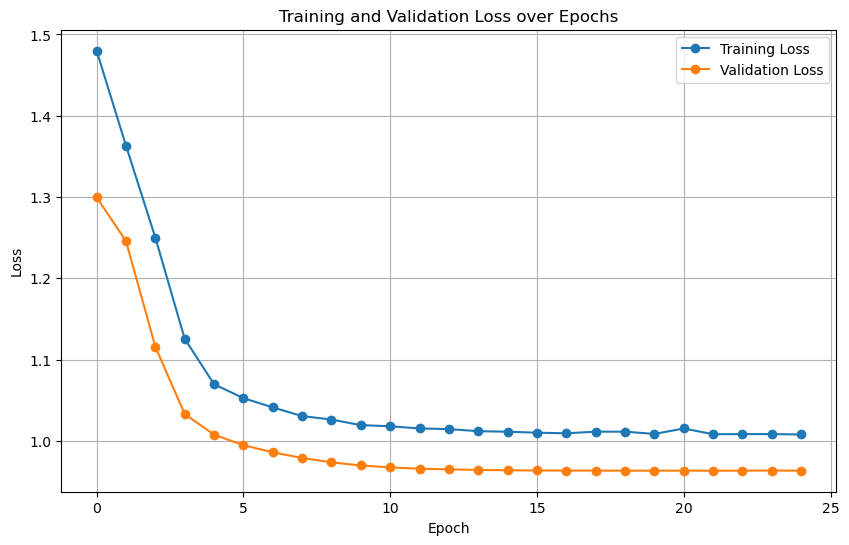

In [11]:
import matplotlib.pyplot as plt

# Assume 'df_logs' is your DataFrame with the logs
# Drop the rows with NaN values for plotting each loss curve separately
df_logs = pd.read_csv("lightning_logs/m1_vae/version_0/metrics.csv")

# Extract relevant columns
epochs = df_logs['epoch'].unique()  # Get unique epoch values
train_loss = df_logs['train_loss'].dropna()  # Drop NaN values for train loss
val_loss = df_logs['val_loss'].dropna()      # Drop NaN values for validation loss

# Plot the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import yaml

# Load the hyperparameters from the hparams.yaml file
hparams_path = 'lightning_logs/m1_vae/version_0/hparams.yaml'  # Replace with the correct path
with open(hparams_path) as file:
    hparams = yaml.safe_load(file)

print(hparams)  # To inspect the hyperparameters


{'dropout_rate': 0.2, 'hidden_dims': [2048, 1024, 512], 'input_dim': 451747, 'latent_dim': 256, 'lr': 1e-06}


In [16]:
from pytorch_lightning import Trainer

checkpoint_path = "lightning_logs/m1_vae/version_0/checkpoints/m1-vae-epoch=21-val_loss=0.96.ckpt"
vae_model = VAE_Lightning.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    **hparams
    )

vae_model.eval()

VAE_Lightning(
  (model): VAE(
    (encoder_layers): Sequential(
      (0): Linear(in_features=451747, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
    (decoder_layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=2048, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (

In [92]:
def get_latent_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            x,y = batch

            x = x.to(device)
            y = y.to(device)
            
            # Replace NaNs with zero or another neutral value for forward pass
            x_filled = replace_nan_with_mean(x)
            # x_filled = torch.nan_to_num(x, nan=0.0)
            
            z, _, _ = model.forward(x_filled)
            embeddings.append(z)
            labels.append(y)
        
        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)

    return embeddings, labels

train_embeddings, train_labels = get_latent_embeddings(vae_model, train_loader)
val_embeddings, val_labels = get_latent_embeddings(vae_model, val_loader)
test_embeddings, test_labels = get_latent_embeddings(vae_model, test_loader)

        